In [1]:
import os
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt


import xgboost as xgb
from sklearn.metrics import mean_squared_error

import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
def add_features(df):
    df['hour'] = df['ds'].apply(lambda x: int(x.split(':')[0]))
    df['min'] = df['ds'].apply(lambda x: int(x.split(':')[1]))
    df['series'] = np.arange(1, len(df) + 1)
    # q_diff는 필요하지 않아보임. 현재까지의 누적량이 영향을 미침.
    # df['q_diff'] = df['q_val'] - df['q_val'].shift(1)
    df.drop(['ds'], axis=1, inplace=True)
    return df

In [3]:
df_list = []
file_list = os.listdir('./data')
for file in file_list:
    df = pd.read_csv(f'./data/{file}', encoding='euc-kr')
    stage = file.split('_')[0]
    for i in range(1, 57):
        # _sc => stage_channel
        df_sc = df[['시간', f'ch{i} 전압', f'ch{i} 전류', f'ch{i} 용량', f'ch{i} PV']]
        df_sc = df_sc.rename(columns={'시간':'ds', f'ch{i} 전압': 'vol', f'ch{i} 전류': 'curr', f'ch{i} 용량': 'q_val',  f'ch{i} PV': 'pv'})
        df_sc.drop(['pv'], axis=1, inplace=True)
        df_sc = add_features(df_sc)
        df_list.append({'stage': stage, 'ch': i, 'data': df_sc})
    print(f'Stage : {stage} loaded.')

Stage : T01730 loaded.
Stage : T75979 loaded.
Stage : T40483 loaded.
Stage : T71411 loaded.


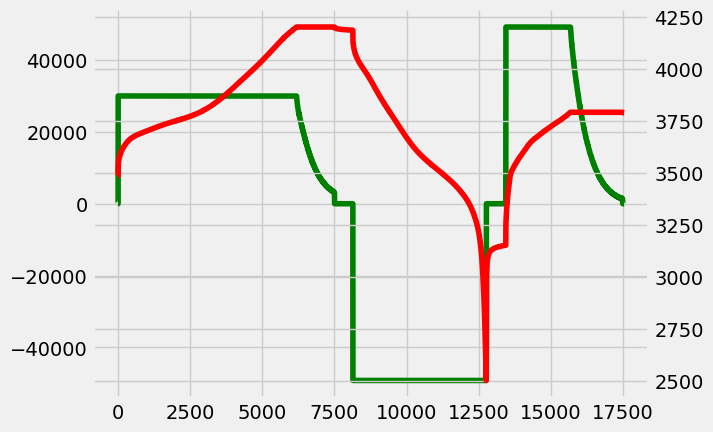

In [4]:
fig, ax1 = plt.subplots()

ax1.plot(df_list[0]['data']['curr'], 'g')
ax2 = ax1.twinx()
ax2.plot(df_list[0]['data']['vol'], 'r')

First of all, I'll create features for time-series.  
Using 'ds', Hour, Min, Second can be extracted and I'll add 'Series' as a additive feature.

In [5]:
FEATURES = ['curr', 'q_val', 'hour', 'min', 'series']
TARGET = 'vol'

In [16]:
from random import randint

draw_list = [randint(0, len(df_list)) for i in range(12)]
print(f'Following data will be used for train and validation, {draw_list}')

df_train = pd.concat([df_list[i]['data'] for i in draw_list[:-1]])
df_test  = pd.concat([df_list[i]['data'] for i in draw_list[-1:]])


Following data will be used for train and validation, [59, 37, 154, 186, 202, 49, 178, 117, 34, 24, 138, 155]


In [17]:
X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]

In [18]:

reg = xgb.XGBRegressor(booster='gbtree', n_estimators=3000, tree_method='gpu_hist', gpu_id=0)
reg.fit(X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100)

[0]	validation_0-rmse:2642.18237	validation_1-rmse:2641.12172
[100]	validation_0-rmse:13.92719	validation_1-rmse:14.89042
[200]	validation_0-rmse:13.85305	validation_1-rmse:14.83382
[300]	validation_0-rmse:13.84187	validation_1-rmse:14.81965
[400]	validation_0-rmse:13.83878	validation_1-rmse:14.81374
[500]	validation_0-rmse:13.83763	validation_1-rmse:14.81020
[600]	validation_0-rmse:13.83709	validation_1-rmse:14.80864
[700]	validation_0-rmse:13.83681	validation_1-rmse:14.80752
[800]	validation_0-rmse:13.83659	validation_1-rmse:14.80691
[900]	validation_0-rmse:13.83647	validation_1-rmse:14.80675
[1000]	validation_0-rmse:13.83641	validation_1-rmse:14.80646
[1100]	validation_0-rmse:13.83635	validation_1-rmse:14.80620
[1200]	validation_0-rmse:13.83633	validation_1-rmse:14.80607
[1300]	validation_0-rmse:13.83630	validation_1-rmse:14.80596
[1400]	validation_0-rmse:13.83629	validation_1-rmse:14.80597
[1500]	validation_0-rmse:13.83628	validation_1-rmse:14.80597
[1600]	validation_0-rmse:13.8362

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=3000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

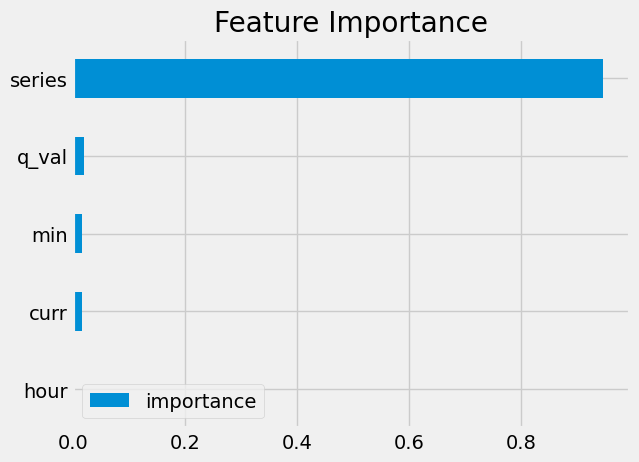

In [9]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [19]:
test = []
score = []
for df in df_list:
    pred = reg.predict(df['data'][FEATURES])
    test.append(pred)
    sc = np.sqrt(mean_squared_error(df['data'][TARGET], pred ))
    score.append(sc)


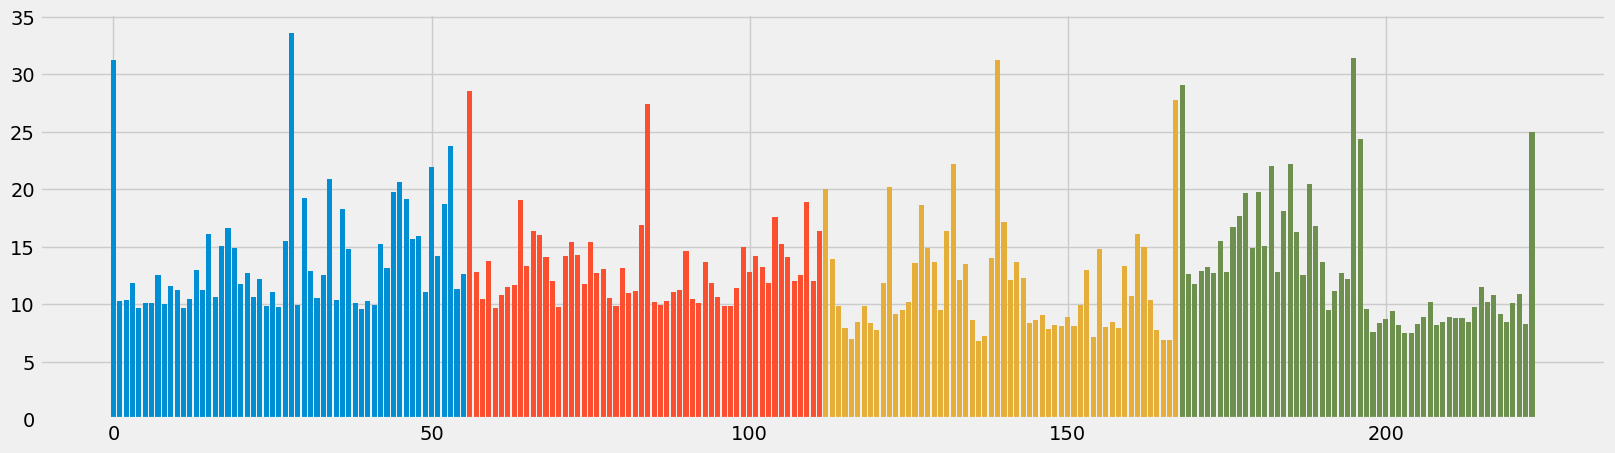

In [20]:
plt.figure(figsize=(18,5))
for i in range(4):
    plt.bar(np.arange(i*56, (i+1)*56), score[i*56:(i+1)*56])


In [13]:
#df_list[0]['data']['q_diff'] = df_list[0]['data']['q_val'] - df_list[0]['data']['q_val'].shift(1)
df_list[0]['data']['q_diff'] = df_list[0]['data']['q_val'] - df_list[0]['data']['q_val'].shift(1)

<BarContainer object of 17535 artists>

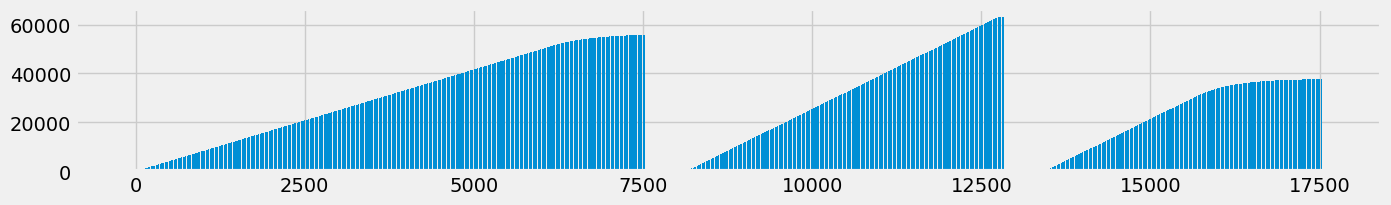

In [14]:
plt.figure(figsize=(15,2))
plt.bar(np.arange(0, len(df_list[0]['data'])), df_list[0]['data']['q_val'])

In [15]:
df_list[0]['data']['q_diff']

0        NaN
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17530    0.0
17531    0.0
17532    0.0
17533    0.0
17534    0.0
Name: q_diff, Length: 17535, dtype: float64

In [16]:
score[0]

28.8416332607911

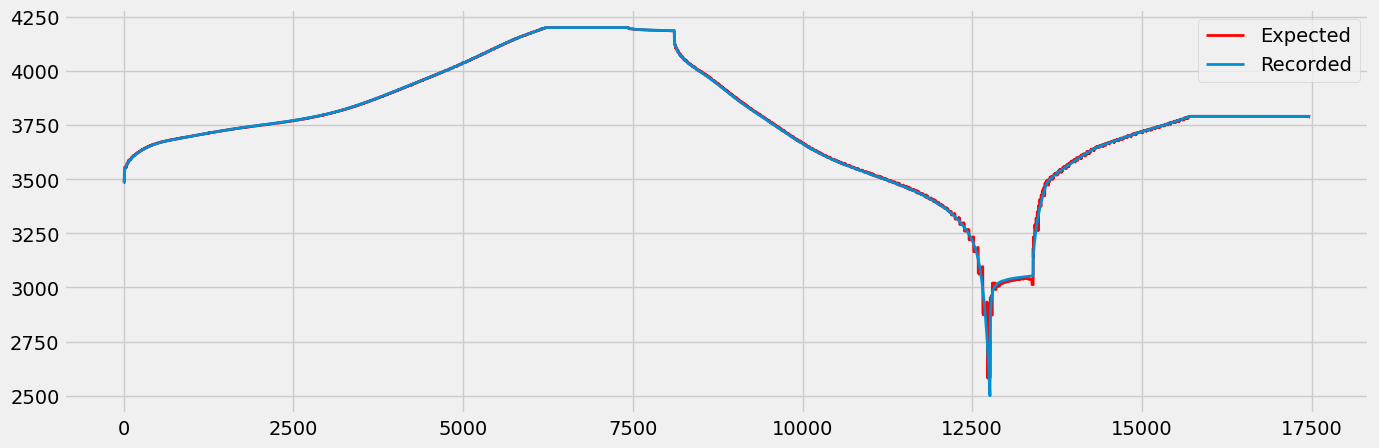

In [23]:
plt.figure(figsize=(15,5))
plt.plot(test[70], 'r', linewidth=2, label='Expected')
plt.plot(df_list[70]['data']['vol'], linewidth=2, label='Acquired')
plt.legend(['Expected', 'Recorded'])

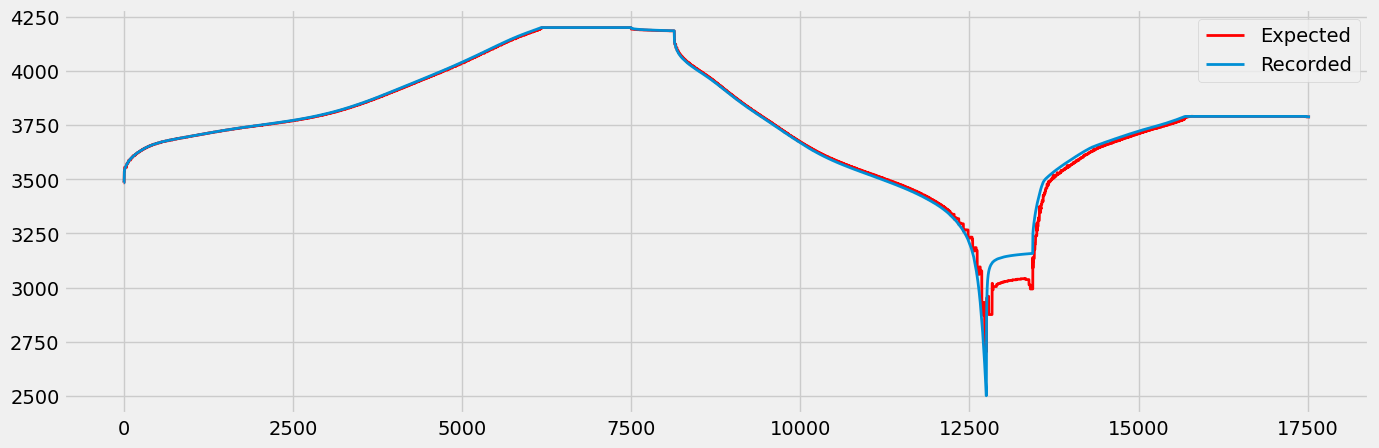

In [24]:
plt.figure(figsize=(15,5))
plt.plot(test[28], 'r', linewidth=2, label='Expected')
plt.plot(df_list[28]['data']['vol'], linewidth=2, label='Acquired')
plt.legend(['Expected', 'Recorded'])

In [22]:
len(score)

224

In [22]:
import plotly.graph_objects as go

x_i = []
for i in range(4):
    for j in range(1, 57):
        x_i.append(j)
x_stage = [f'stage {j}' for j in range(1,5) for i in range(56)]


fig = go.Figure()
fig.add_bar(y=score, x=[x_stage,x_i])
# fig.update_layout(barmode='relative')
fig.show()


In [15]:
import plotly.express as px
histo = []
for i in range(4):
    for j in range(10):
        histo.append([i, j, 0])
d = np.array(histo)


for i, v in enumerate(score):
    stage = int(i / 56) 
    cat = int(score[i] / 10)
    d[stage*10 + cat,-1] += 1

fig = px.bar(d, x=d[:,0], y=d[:,2], color=d[:,1], text_auto=True)
fig.show()
